In [1]:
using Revise, OrdinaryDiffEq, Flux, DiffEqFlux, Optim
using Plots, FileIO, JLD2, OffsetArrays, ProgressMeter, Kinetic

┌ Info: Precompiling OrdinaryDiffEq [1dea7af3-3e70-54e6-95c3-0bf5283fa5ed]
└ @ Base loading.jl:1260
┌ Info: Precompiling Flux [587475ba-b771-5e3f-ad9e-33799f191a9c]
└ @ Base loading.jl:1260
┌ Info: Precompiling DiffEqFlux [aae7a2af-3d4f-5e19-a356-7da93b79d9d0]
└ @ Base loading.jl:1260
┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1260
┌ Error: (compiled mode) evaluation error starting at /home/vavrines/.julia/packages/DistributionsAD/BtYLj/src/reversediff.jl:19
│   mod = DistributionsAD.ReverseDiffX
│   ex = begin
    #= /home/vavrines/.julia/packages/DistributionsAD/BtYLj/src/reversediff.jl:19 =#
    const RDBroadcasted{F, T} = Broadcasted{<:Any, <:Any, F, T}
end
│   exception = (ErrorException("invalid redefinition of constant RDBroadcasted"), Union{Ptr{Nothing}, Base.InterpreterIP}[Ptr{Nothing} @0x00007f68f4cd472f, Ptr{Nothing} @0x00007f68f4d6194c, Ptr{Nothing} @0x00007f68f4d640f8, Ptr{Nothing} @0x00007f68f4d64fe7, Base.InterpreterIP in top-le

In [2]:
@load "sol1d.jld2" ks ctr

2-element Array{Symbol,1}:
 :ks
 :ctr

In [3]:
vMeshType = "rectangle"
umin = ks.vSpace.u0
umax = ks.vSpace.u1
nu = ks.vSpace.nu
vmin = ks.vSpace.u0
vmax = ks.vSpace.u1
nv = 28
nvg = 0
wmin = ks.vSpace.u0
wmax = ks.vSpace.u1
nw = 28
nwg = 0
nm = 5
tLen = 3
nh = 12;

In [4]:
vSpace2D = VSpace2D(vmin, vmax, nv, wmin, wmax, nw, vMeshType)
vSpace3D = VSpace3D(umin, umax, nu, vmin, vmax, nv, wmin, wmax, nw, vMeshType)

kn_bzm = hs_boltz_kn(ks.gas.μᵣ, 1.0)
sos = sound_speed(ks.ib.primR, ks.gas.γ)
tmax = (ks.vSpace.u1 + sos) / ks.pSpace.dx[1]
dt = Float32(ks.set.cfl / tmax)
tspan = (0.f0, dt)
tran = range(tspan[1], tspan[2], length = tLen);

In [5]:
#--- Boltzmann dataset ---#
f_full = Array{Float32}(undef, ks.vSpace.nu, nv, nw, ks.pSpace.nx)
for i = 1:ks.pSpace.nx
    f_full[:, :, :, i] .= full_distribution(
        ctr[i].h,
        ctr[i].b,
        ks.vSpace.u,
        ks.vSpace.weights,
        vSpace3D.v,
        vSpace3D.w,
        ctr[i].prim,
        ks.gas.γ,
    )
end

phi, psi, phipsi = kernel_mode(
    nm,
    vSpace3D.u1,
    vSpace3D.v1,
    vSpace3D.w1,
    vSpace3D.du[1, 1, 1],
    vSpace3D.dv[1, 1, 1],
    vSpace3D.dw[1, 1, 1],
    vSpace3D.nu,
    vSpace3D.nv,
    vSpace3D.nw,
    ks.gas.αᵣ,
)

function boltzmann(f, p, t)
    Kn, M, phi, psi, phipsi = p
    return boltzmann_fft(f[1:end,1:end,1:end], Kn, M, phi, psi, phipsi)
end

function boltzmann!(df, f, p, t)
    Kn, M, phi, psi, phipsi = p
    df .= boltzmann_fft(f, Kn, M, phi, psi, phipsi)
end

data_boltz = zeros(Float32, ks.vSpace.nu, nv, nw, ks.pSpace.nx, tLen)
for i = 1:ks.pSpace.nx
    prob = ODEProblem(
        boltzmann!,
        f_full[:, :, :, i],
        tspan,
        [kn_bzm, nm, phi, psi, phipsi],
    )

    data_boltz[:, :, :, i, :] = solve(prob, Tsit5(), saveat = tran) |> Array
end

h_boltz = zeros(Float32, ks.vSpace.nu, ks.pSpace.nx, tLen)
b_boltz = zeros(Float32, ks.vSpace.nu, ks.pSpace.nx, tLen)
for j = 1:tLen, i = 1:ks.pSpace.nx
    h_boltz[:, i, j], b_boltz[:, i, j] = reduce_distribution(
        data_boltz[:, :, :, i, j],
        vSpace3D.v,
        vSpace3D.w,
        vSpace2D.weights,
    )
end
Y = vcat(h_boltz, b_boltz);

In [6]:
#--- BGK dataset ---#
function bgk!(df, f, p, t)
    H, B, tau = p
    df[1:end÷2, :] .= (H .- f[1:end÷2, :]) ./ tau
    df[end÷2+1:end, :] .= (B .- f[end÷2+1:end, :]) ./ tau
end

X = Array{Float32}(undef, nu * 2, ks.pSpace.nx)
for i = 1:ks.pSpace.nx
    X[1:nu, i] .= ctr[i].h
    X[nu+1:end, i] .= ctr[i].b
end

H = Array{Float32}(undef, nu, ks.pSpace.nx)
B = Array{Float32}(undef, nu, ks.pSpace.nx)
τ = Array{Float32}(undef, 1, ks.pSpace.nx)
for i = 1:ks.pSpace.nx
    H[:, i] .= maxwellian(ks.vSpace.u, ctr[i].prim)
    B[:, i] .= H[:, i] .* ks.gas.K ./ (2.0 .* ctr[i].prim[end])
    τ[1, i] = vhs_collision_time(ctr[i].prim, ks.gas.μᵣ, ks.gas.ω)
end
P = [H, B, τ]

prob = ODEProblem(bgk!, X, tspan, P)
Y1 = solve(prob, Midpoint(), saveat = tran) |> Array;

#=
qf = Array{Float32}(undef, ks.pSpace.nx)
SH = Array{Float32}(undef, nu, ks.pSpace.nx)
SB = Array{Float32}(undef, nu, ks.pSpace.nx)
for i = 1:ks.pSpace.nx
    qf[i] = heat_flux(ctr[i].h, ctr[i].b, ctr[i].prim, ks.vSpace.u, ks.vSpace.weights)
    SH[:, i], SB[:, i] = shakhov(ks.vSpace.u, H[:, i], B[:, i], qf[i], ctr[i].prim, ks.gas.Pr, ks.gas.K)
    SH[:, i] .+= H[:, i] .+ SH[:, i]
    SB[:, i] .+= B[:, i] .+ SB[:, i]
end
PS = [SH, SB, τ];
=#

96×50×3 Array{Float32,3}:
[:, :, 1] =
 0.0          -8.62334f-13  -1.01498f-12  …  -6.31271f-14  3.25519f-24
 0.0           3.07361f-13   3.35859f-13      3.54352f-14  2.09243f-22
 0.0           1.22118f-12   1.25786f-12     -1.67577f-14  1.13805f-20
 0.0          -8.5086f-13   -8.6219f-13      -3.86033f-14  5.23732f-19
 5.6f-44      -9.16916f-13  -9.24898f-13      4.47824f-13  2.03935f-17
 1.88221f-40   2.24548f-11   2.2861f-11   …  -2.26154f-12  6.71912f-16
 4.46445f-37  -4.4555f-11   -4.65967f-11      8.12398f-12  1.87313f-14
 7.48289f-34   3.56334f-11   3.91497f-11     -2.23086f-11  4.41835f-13
 8.86287f-31  -1.17641f-11  -1.39135f-11      6.15249f-11  8.81837f-12
 7.41794f-28   1.17874f-12   1.77566f-12      4.5586f-11   1.4892f-10
 4.38727f-25   2.7523f-12    2.79068f-12  …   2.31784f-9   2.12791f-9
 1.83362f-22  -4.15523f-12  -4.03865f-12      2.55441f-8   2.5727f-8
 5.41537f-20   2.6023f-13   -8.12107f-13      2.64508f-7   2.63186f-7
 ⋮                                        ⋱ 

In [7]:
#--- universal differential equation ---#
model_univ = FastChain(
    #(x, p) -> zeros(eltype(x), axes(x)),
    FastDense(ks.vSpace.nu * 2, ks.vSpace.nu * 2 * nh, tanh),
    #FastDense(ks.vSpace.nu * 2 * nh, ks.vSpace.nu * 2 * nh, tanh),
    FastDense(ks.vSpace.nu * 2 * nh, ks.vSpace.nu * 2),
)

p_model = initial_params(model_univ)

function dfdt(f, p, t)
    h = f[1:nu, :]
    b = f[nu+1:end, :]

    dh = (H .- h) ./ τ .+ model_univ(f, p)[1:nu, :]
    db = (B .- b) ./ τ .+ model_univ(f, p)[nu+1:end, :]
    #dh = (SH .- h) ./ τ .+ model_univ(f, p)[1:nu, :]
    #db = (SB .- b) ./ τ .+ model_univ(f, p)[nu+1:end, :]

    df = vcat(dh, db)
end

#function dfdt!(df, f, p, t)
#    h = f[1:nu, :]
#    b = f[nu+1:end, :]

#    dh = (H .- h) ./ τ .+ model_univ(f, p)[1:nu, :]
#    db = (B .- b) ./ τ .+ model_univ(f, p)[nu+1:end, :]

#    df[1:nu, :] .= dh
#    df[nu+1:end, :] .= db
#end

prob_ube = ODEProblem(dfdt, X, tspan, p_model)

function loss(p)
    sol_ube = solve(prob_ube, Midpoint(), u0=X, p=p, saveat=tran)
    loss = sum(abs2, Array(sol_ube) .- Y)
    #loss = sum(abs2, Array(sol_ube) .- Y1)
    return loss
end

cb = function (p, l)
    display(l)
    return false
end

#5 (generic function with 1 method)

In [8]:
res = DiffEqFlux.sciml_train(loss, p_model, ADAM(), cb=Flux.throttle(cb, 1), maxiters=200)

0.42933068f0

loss: 0.121:   1%|▍                                        |  ETA: 0:04:04

0.12140418f0

loss: 0.164:   2%|▉                                        |  ETA: 0:04:01

0.14166985f0

loss: 0.0822:   3%|█▎                                       |  ETA: 0:03:48

0.038174395f0

loss: 0.0428:   4%|█▉                                       |  ETA: 0:03:24

0.059324816f0

loss: 0.0581:   6%|██▌                                      |  ETA: 0:03:12

0.04240032f0

loss: 0.0149:   8%|███▏                                     |  ETA: 0:02:59

0.01277978f0

loss: 0.0246:   9%|███▊                                     |  ETA: 0:02:51

0.028190201f0

loss: 0.0197:  10%|████▎                                    |  ETA: 0:02:45

0.012723617f0

loss: 0.00666:  12%|████▉                                    |  ETA: 0:02:37

0.0083929915f0

loss: 0.0134:  14%|█████▌                                   |  ETA: 0:02:31m

0.013234716f0

loss: 0.00831:  15%|██████▏                                  |  ETA: 0:02:27

0.0059596174f0

loss: 0.00483:  16%|██████▊                                  |  ETA: 0:02:24

0.0057990327f0

loss: 0.00737:  18%|███████▍                                 |  ETA: 0:02:20

0.006958236f0

loss: 0.00462:  20%|████████                                 |  ETA: 0:02:15

0.003788054f0

loss: 0.00403:  21%|████████▋                                |  ETA: 0:02:10

0.0045298086f0

loss: 0.00463:  22%|█████████▎                               |  ETA: 0:02:06

0.004212573f0

loss: 0.00338:  24%|█████████▉                               |  ETA: 0:02:02

0.0032587228f0

loss: 0.00354:  26%|██████████▌                              |  ETA: 0:01:58

0.0036889266f0

loss: 0.00346:  27%|███████████▏                             |  ETA: 0:01:54

0.0031813965f0

loss: 0.00293:  28%|███████████▋                             |  ETA: 0:01:50

0.0030341456f0

loss: 0.0032:  30%|████████████▎                            |  ETA: 0:01:47m

0.003121505f0

loss: 0.0029:  32%|████████████▉                            |  ETA: 0:01:43m

0.0028426554f0

loss: 0.00286:  33%|█████████████▌                           |  ETA: 0:01:39

0.002888699f0

loss: 0.00285:  34%|██████████████▏                          |  ETA: 0:01:36

0.002785695f0

loss: 0.00272:  36%|███████████████                          |  ETA: 0:01:31

0.0027382288f0

loss: 0.00272:  38%|███████████████▋                         |  ETA: 0:01:28

0.0026851064f0

loss: 0.00263:  40%|████████████████▍                        |  ETA: 0:01:24

0.0026367693f0

loss: 0.0026:  42%|█████████████████▎                       |  ETA: 0:01:20m

0.002579885f0

loss: 0.00256:  44%|██████████████████                       |  ETA: 0:01:15

0.0025530402f0

loss: 0.00252:  46%|██████████████████▉                      |  ETA: 0:01:12

0.0025042207f0

loss: 0.00249:  48%|███████████████████▋                     |  ETA: 0:01:08

0.0024776678f0

loss: 0.00245:  50%|████████████████████▌                    |  ETA: 0:01:05

0.0024421345f0

loss: 0.00242:  52%|█████████████████████▍                   |  ETA: 0:01:01

0.0024117576f0

loss: 0.00239:  54%|██████████████████████▏                  |  ETA: 0:00:58

0.002384019f0

loss: 0.00236:  56%|███████████████████████                  |  ETA: 0:00:55

0.0023551714f0

loss: 0.00234:  58%|███████████████████████▊                 |  ETA: 0:00:52

0.0023299325f0

loss: 0.00231:  60%|████████████████████████▋                |  ETA: 0:00:49

0.0023048108f0

loss: 0.00229:  62%|█████████████████████████▍               |  ETA: 0:00:46

0.0022810025f0

loss: 0.00226:  64%|██████████████████████████▎              |  ETA: 0:00:43

0.0022588084f0

loss: 0.00224:  66%|███████████████████████████              |  ETA: 0:00:40

0.0022373367f0

loss: 0.00222:  68%|███████████████████████████▉             |  ETA: 0:00:38

0.0022171608f0

loss: 0.0022:  70%|████████████████████████████▊            |  ETA: 0:00:35m

0.0021980947f0

loss: 0.00218:  72%|█████████████████████████████▌           |  ETA: 0:00:33

0.00217995f0

loss: 0.00217:  74%|██████████████████████████████▍          |  ETA: 0:00:30

0.0021628714f0

loss: 0.00215:  76%|███████████████████████████████▏         |  ETA: 0:00:28

0.0021467442f0

loss: 0.00214:  78%|████████████████████████████████         |  ETA: 0:00:25

0.0021315312f0

loss: 0.00212:  80%|████████████████████████████████▊        |  ETA: 0:00:23

0.0021172205f0

loss: 0.00211:  82%|█████████████████████████████████▋       |  ETA: 0:00:20

0.0021037564f0

loss: 0.00209:  84%|██████████████████████████████████▌      |  ETA: 0:00:18

0.0020910911f0

loss: 0.00208:  86%|███████████████████████████████████▎     |  ETA: 0:00:16

0.0020792116f0

loss: 0.00207:  88%|████████████████████████████████████▏    |  ETA: 0:00:13

0.0020680614f0

loss: 0.00206:  90%|████████████████████████████████████▉    |  ETA: 0:00:11

0.0020576061f0

loss: 0.00205:  92%|█████████████████████████████████████▊   |  ETA: 0:00:09

0.0020478154f0

loss: 0.00204:  94%|██████████████████████████████████████▌  |  ETA: 0:00:07

0.0020386411f0

loss: 0.00203:  96%|███████████████████████████████████████▍ |  ETA: 0:00:04

0.0020300567f0

loss: 0.00202:  98%|████████████████████████████████████████▏|  ETA: 0:00:02

0.0020220217f0

loss: 0.00202: 100%|█████████████████████████████████████████| Time: 0:01:48


0.0020163371f0

 * Status: success

 * Candidate solution
    Final objective value:     2.016337e-03

 * Found with
    Algorithm:     ADAM

 * Convergence measures
    |x - x'|               = NaN ≰ 0.0e+00
    |x - x'|/|x'|          = NaN ≰ 0.0e+00
    |f(x) - f(x')|         = NaN ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = NaN ≰ 0.0e+00
    |g(x)|                 = NaN ≰ 0.0e+00

 * Work counters
    Seconds run:   157  (vs limit Inf)
    Iterations:    200
    f(x) calls:    200
    ∇f(x) calls:   200


In [9]:
res = DiffEqFlux.sciml_train(loss, res.minimizer, ADAM(), cb=Flux.throttle(cb, 1), maxiters=200)

0.0020145075f0

loss: 0.0215:   2%|▉                                        |  ETA: 0:02:10

0.029700682f0

loss: 0.0226:   4%|█▍                                       |  ETA: 0:02:25

0.014347658f0

loss: 0.0171:   5%|██                                       |  ETA: 0:02:26

0.015837636f0

loss: 0.00899:   6%|██▋                                      |  ETA: 0:02:23

0.008248918f0

loss: 0.00911:   8%|███▏                                     |  ETA: 0:02:25

0.009661076f0

loss: 0.0066:   9%|███▊                                     |  ETA: 0:02:22m

0.005022198f0

loss: 0.00593:  10%|████▎                                    |  ETA: 0:02:18

0.0063185804f0

loss: 0.00414:  12%|████▉                                    |  ETA: 0:02:14

0.003291605f0

loss: 0.00427:  14%|█████▌                                   |  ETA: 0:02:09

0.0045318087f0

loss: 0.00289:  15%|██████▏                                  |  ETA: 0:02:05

0.002487522f0

loss: 0.00343:  16%|██████▊                                  |  ETA: 0:02:01

0.0034444379f0

loss: 0.00228:  18%|███████▍                                 |  ETA: 0:01:57

0.0022153016f0

loss: 0.0029:  20%|████████                                 |  ETA: 0:01:53m

0.0027359563f0

loss: 0.00204:  21%|████████▋                                |  ETA: 0:01:49

0.0021772294f0

loss: 0.0025:  22%|█████████▎                               |  ETA: 0:01:46m

0.002268218f0

loss: 0.00218:  24%|██████████                               |  ETA: 0:01:41

0.0022782164f0

loss: 0.00203:  26%|██████████▋                              |  ETA: 0:01:38

0.001968839f0

loss: 0.00213:  28%|███████████▎                             |  ETA: 0:01:35

0.0021098424f0

loss: 0.00199:  30%|████████████▏                            |  ETA: 0:01:30

0.0020398274f0

loss: 0.00199:  31%|████████████▊                            |  ETA: 0:01:28

0.0019539737f0

loss: 0.00199:  33%|█████████████▌                           |  ETA: 0:01:24

0.0019679195f0

loss: 0.00196:  35%|██████████████▍                          |  ETA: 0:01:20

0.00196066f0

loss: 0.00193:  37%|███████████████▏                         |  ETA: 0:01:16

0.0019395831f0

loss: 0.00193:  39%|████████████████                         |  ETA: 0:01:13

0.0019261062f0

loss: 0.00193:  41%|████████████████▊                        |  ETA: 0:01:10

0.0019223444f0

loss: 0.00192:  43%|█████████████████▋                       |  ETA: 0:01:07

0.0019212724f0

loss: 0.00192:  45%|██████████████████▌                      |  ETA: 0:01:03

0.0019190109f0

loss: 0.00191:  47%|███████████████████▎                     |  ETA: 0:01:01

0.0019157066f0

loss: 0.00191:  49%|████████████████████▏                    |  ETA: 0:00:58

0.0019126734f0

loss: 0.00191:  50%|████████████████████▊                    |  ETA: 0:00:56

0.0019102363f0

loss: 0.00191:  52%|█████████████████████▌                   |  ETA: 0:00:53

0.0019091249f0

loss: 0.00191:  54%|██████████████████████▍                  |  ETA: 0:00:51

0.0019081605f0

loss: 0.00191:  56%|███████████████████████▏                 |  ETA: 0:00:48

0.0019072427f0

loss: 0.00191:  58%|████████████████████████                 |  ETA: 0:00:45

0.0019063886f0

loss: 0.00191:  60%|████████████████████████▊                |  ETA: 0:00:43

0.0019056376f0

loss: 0.00191:  62%|█████████████████████████▋               |  ETA: 0:00:40

0.0019049871f0

loss: 0.0019:  64%|██████████████████████████▌              |  ETA: 0:00:38

0.0019044278f0

loss: 0.0019:  66%|███████████████████████████▎             |  ETA: 0:00:36

0.001903943f0

loss: 0.0019:  68%|████████████████████████████▏            |  ETA: 0:00:33

0.0019035125f0

loss: 0.0019:  70%|████████████████████████████▉            |  ETA: 0:00:31

0.0019031317f0

loss: 0.0019:  72%|█████████████████████████████▊           |  ETA: 0:00:29

0.0019027919f0

loss: 0.0019:  74%|██████████████████████████████▌          |  ETA: 0:00:26

0.0019024792f0

loss: 0.0019:  76%|███████████████████████████████▍         |  ETA: 0:00:24

0.0019021878f0

loss: 0.0019:  78%|████████████████████████████████▏        |  ETA: 0:00:22

0.0019019175f0

loss: 0.0019:  80%|█████████████████████████████████        |  ETA: 0:00:20

0.0019016614f0

loss: 0.0019:  82%|█████████████████████████████████▉       |  ETA: 0:00:18

0.001901415f0

loss: 0.0019:  84%|██████████████████████████████████▋      |  ETA: 0:00:16

0.0019011801f0

loss: 0.0019:  86%|███████████████████████████████████▌     |  ETA: 0:00:14

0.0019009585f0

loss: 0.0019:  88%|████████████████████████████████████▎    |  ETA: 0:00:12

0.0019007344f0

loss: 0.0019:  90%|█████████████████████████████████████▏   |  ETA: 0:00:09

0.0019005202f0

loss: 0.0019:  92%|█████████████████████████████████████▉   |  ETA: 0:00:07

0.0019003064f0

loss: 0.0019:  94%|██████████████████████████████████████▊  |  ETA: 0:00:05

0.0019001018f0

loss: 0.0019:  96%|███████████████████████████████████████▋ |  ETA: 0:00:03

0.0018998948f0

loss: 0.0019:  98%|████████████████████████████████████████▍|  ETA: 0:00:01

0.0018996871f0

loss: 0.0019: 100%|█████████████████████████████████████████| Time: 0:01:38


 * Status: success

 * Candidate solution
    Final objective value:     1.899584e-03

 * Found with
    Algorithm:     ADAM

 * Convergence measures
    |x - x'|               = NaN ≰ 0.0e+00
    |x - x'|/|x'|          = NaN ≰ 0.0e+00
    |f(x) - f(x')|         = NaN ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = NaN ≰ 0.0e+00
    |g(x)|                 = NaN ≰ 0.0e+00

 * Work counters
    Seconds run:   98  (vs limit Inf)
    Iterations:    200
    f(x) calls:    200
    ∇f(x) calls:   200


In [ ]:
res = DiffEqFlux.sciml_train(loss, res.minimizer, LBFGS(), cb=Flux.throttle(cb, 1), maxiters=200)

In [10]:
function nbe_rhs!(df, f, p, t)
    H = p[1:nu]
    B = p[nu+1:2*nu]
    τ = p[2*nu+1]
    p_nn = p[2*nu+2:end]

    h = f[1:nu]
    b = f[nu+1:end]

    dh = (H .- h) ./ τ .+ model_univ(f, p_nn)[1:nu]
    db = (B .- b) ./ τ .+ model_univ(f, p_nn)[nu+1:end]

    df[1:nu] .= dh
    df[nu+1:end] .= db
end

ube = ODEProblem(
    nbe_rhs!,
    [ctr[1].h; ctr[1].b],
    tspan,
    [H[:, 1]; B[:, 1]; τ[1, 1]; res.minimizer],
);

In [11]:
function step_nbe!(
    fwL,
    fhL,
    fbL,
    w,
    prim,
    h,
    b,
    fwR,
    fhR,
    fbR,
    K,
    γ,
    μ,
    ω,
    u,
    weights,
    p,
    dx,
    tran,
    RES,
    AVG,
)

    #--- record W^{n} ---#
    w_old = deepcopy(w)
    H = maxwellian(u, prim)
    B = H .* K ./ (2.0 .* prim[end])
    τ = vhs_collision_time(prim, μ, ω)
    
    #qf = heat_flux(h, b, prim, u, weights)
    #SH, SB = shakhov(u, H, B, qf, prim, ks.gas.Pr, K)
    
    #--- update W^{n+1} ---#
    @. w += (fwL - fwR) / dx
    prim .= conserve_prim(w, γ)

    #--- record residuals ---#
    @. RES += (w - w_old)^2
    @. AVG += abs(w)

    #--- update f^{n+1} ---#
    sol = solve(ube, Midpoint(), u0=[h; b], p=[H; B; τ; p], saveat=tran)
    #sol = solve(ube, Midpoint(), u0=[h; b], p=[SH; SB; τ; p], saveat=tran)
    
    hstar = sol.u[end][1:length(h)]
    bstar = sol.u[end][length(h)+1:end]
    for i in eachindex(h)
        h[i] = hstar[i] + (fhL[i] - fhR[i]) / dx
        b[i] = bstar[i] + (fbL[i] - fbR[i]) / dx
    end

end

step_nbe! (generic function with 1 method)

In [12]:
face = Array{Interface1D2F}(undef, ks.pSpace.nx + 1)
for i = 1:ks.pSpace.nx+1
    face[i] = Interface1D2F(ks.ib.wL, ks.ib.hL)
end

sumRes = zeros(Float32, axes(ks.ib.wL))
sumAvg = zeros(Float32, axes(ks.ib.wL))

3-element Array{Float32,1}:
 0.0
 0.0
 0.0

In [18]:
# loop of neural Boltzmann equation
@showprogress for iter = 1:10
    Kinetic.evolve!(ks, ctr, face, dt)

    for i = 2:49
        step_nbe!(
            face[i].fw,
            face[i].fh,
            face[i].fb,
            ctr[i].w,
            ctr[i].prim,
            ctr[i].h,
            ctr[i].b,
            face[i+1].fw,
            face[i+1].fh,
            face[i+1].fb,
            ks.gas.K,
            ks.gas.γ,
            ks.gas.μᵣ,
            ks.gas.ω,
            ks.vSpace.u,
            ks.vSpace.weights,
            res.minimizer,
            ctr[i].dx,
            tran,
            sumRes,
            sumAvg,
        )
    end
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:15


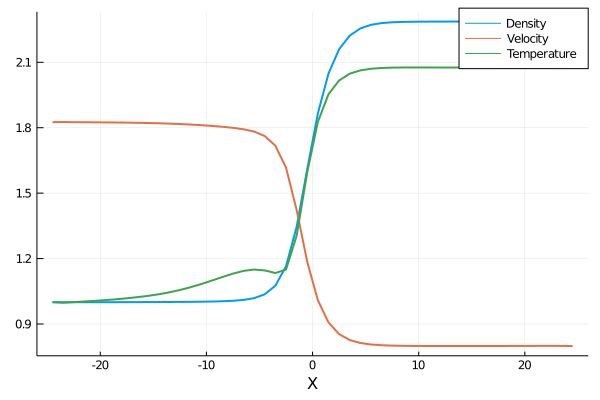

In [19]:
plot_line(ks, ctr)

In [ ]:
ctr = OffsetArray{ControlVolume1D2F}(undef, eachindex(ks.pSpace.x))
face = Array{Interface1D2F}(undef, ks.pSpace.nx + 1)
for i in eachindex(ctr)
    if i <= ks.pSpace.nx ÷ 2
        ctr[i] = ControlVolume1D2F(
            ks.pSpace.x[i],
            ks.pSpace.dx[i],
            Float32.(ks.ib.wL),
            Float32.(ks.ib.primL),
            Float32.(ks.ib.hL),
            Float32.(ks.ib.bL),
        )
    else
        ctr[i] = ControlVolume1D2F(
            ks.pSpace.x[i],
            ks.pSpace.dx[i],
            Float32.(ks.ib.wR),
            Float32.(ks.ib.primR),
            Float32.(ks.ib.hR),
            Float32.(ks.ib.bR),
        )
    end
end
for i = 1:ks.pSpace.nx+1
    face[i] = Interface1D2F(ks.ib.wL, ks.ib.hL)
end

In [26]:
hcat(test,randn(96),randn(96))

96×4 Array{Float64,2}:
 0.0          0.0          -1.36236    -1.34702
 0.0          0.0          -0.758317    1.78849
 0.0          0.0          -1.10277     1.58708
 0.0          0.0           1.02725     0.741366
 5.60519e-44  5.60519e-44  -0.70784     0.247827
 1.88221e-40  1.88221e-40   1.18105    -0.36038
 4.46445e-37  4.46445e-37  -1.01389    -0.199139
 7.48289e-34  7.48289e-34  -1.00335     1.6528
 8.86287e-31  8.86287e-31  -1.75861    -0.634582
 7.41794e-28  7.41794e-28  -0.932249    0.347902
 4.38727e-25  4.38727e-25   0.252856   -0.625677
 1.83362e-22  1.83362e-22   2.94716     0.853839
 5.41537e-20  5.41537e-20   0.284651    0.410991
 ⋮                                     
 6.05704e-6   6.05704e-6    0.482647   -0.9471
 3.03851e-7   3.03851e-7    0.0235018   2.88077
 1.07712e-8   1.07712e-8   -0.784148   -0.134042
 2.69819e-10  2.69819e-10   1.2063      0.888896
 4.77622e-12  4.77622e-12  -0.273218   -0.0897954
 5.97445e-14  5.97445e-14  -0.953194   -1.64298
 5.28099e-16  5

In [25]:
test = hcat(test,test)

96×2 Array{Float32,2}:
 0.0          0.0
 0.0          0.0
 0.0          0.0
 0.0          0.0
 5.6f-44      5.6f-44
 1.88221f-40  1.88221f-40
 4.46445f-37  4.46445f-37
 7.48289f-34  7.48289f-34
 8.86287f-31  8.86287f-31
 7.41794f-28  7.41794f-28
 4.38727f-25  4.38727f-25
 1.83362f-22  1.83362f-22
 5.41537f-20  5.41537f-20
 ⋮            
 6.05704f-6   6.05704f-6
 3.03851f-7   3.03851f-7
 1.07712f-8   1.07712f-8
 2.69819f-10  2.69819f-10
 4.77622f-12  4.77622f-12
 5.97445f-14  5.97445f-14
 5.28099f-16  5.28099f-16
 3.29865f-18  3.29865f-18
 1.456f-20    1.456f-20
 4.54138f-23  4.54138f-23
 1.00096f-25  1.00096f-25
 1.55902f-28  1.55902f-28

In [ ]:
#--- neural ODE ---#
model_univ = FastChain(
    #(x, p) -> zeros(eltype(x), axes(x)),
    FastDense(ks.vSpace.nu * 2, ks.vSpace.nu * 2 * nh, tanh),
    FastDense(ks.vSpace.nu * 2 * nh, ks.vSpace.nu * 2),
)

p_model = initial_params(model_univ)

function dfdt(f, p, t)
    h = f[1:nu, :]
    b = f[nu+1:end, :]

    df = model_univ(f, p)
end

prob_ube = ODEProblem(dfdt, X, tspan, p_model)

function loss(p)
    sol_ube = solve(prob_ube, Midpoint(), u0=X, p=p, saveat=tran)
    loss = sum(abs2, Array(sol_ube) .- Y)
    #loss = sum(abs2, Array(sol_ube) .- Y1)
    return loss
end

cb = function (p, l)
    display(l)
    return false
end